**IMPORTANT INFORMATION:** Two models were left on purpose so we could compare the difference between the first bad one and the second one were more funtionalities were added

##########IMPORTS##############

In [11]:
import keras.backend as K
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow import keras
from keras.layers.core.dropout import Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import BatchNormalization
from pandas import DataFrame
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive
import matplotlib.pyplot as plt

###########GOOGLE DRIVE MOUNT#############

In [12]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###########KAGGLE INFORMATION#############

In [13]:
os.environ['KAGGLE_USERNAME'] = 'davidreto'  # Your Kaggle username
os.environ['KAGGLE_KEY'] = '505caa4aee2ecd6bc8ae5f457a190351'  # Your Kaggle API key
os.environ['URN'] = '6647000'  # Your URN: submissions without a URN will not count

##########DATASET DOWNLOAD###############

In [14]:
!cp -r /content/gdrive/MyDrive/Colab_Notebooks/Coursework_dataset_COM2028_21-22.zip /content/Coursework_dataset_COM2028_21-22.zip
!unzip /content/Coursework_dataset_COM2028_21-22.zip  

Archive:  /content/Coursework_dataset_COM2028_21-22.zip
replace test/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##########ADDING EXTENSION AFTER THE ID TO GET THE PICTURE#################

In [15]:

df = pd.read_csv('train.csv',dtype=str)
col = []
for i in df["Id"]:
 col.append(i+".jpg")
df["filename"] = col

df
  

,Id,Cell type,filename
0,000000,3,000000.jpg
1,000001,3,000001.jpg
2,000002,0,000002.jpg
3,000003,2,000003.jpg
4,000004,0,000004.jpg
...,...,...,...
149995,149995,7,149995.jpg
149996,149996,7,149996.jpg
149997,149997,3,149997.jpg
149998,149998,7,149998.jpg


#######################DATASET TREATING AND RETRIVAL#########################

In [16]:
colour_mode = 'grayscale'
image_size = (28, 28)
batch_size = 100



checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints',
    save_weights_only=True,  # Record only weights (see model.save_weights vs model.save)
    monitor='val_accuracy',  # Evaluate model using accuracy metric on the validation set
    mode='max',  # Determine best model based on 'max' of the 'val_accuracy' score
    save_best_only=True)  # Keep only the best-performing model (i.e. overwrite only when the model has improved)

train_datagen = ImageDataGenerator(
    validation_split =0.2)

train_dataset = train_datagen.flow_from_dataframe(
  dataframe=df,
  directory='train',
  color_mode=colour_mode,
  
  y_col="Cell type",
  x_col="filename",
  subset='training',
  seed=42,
  class_mode='categorical',  # There are 8 classes for this task.
  target_size=image_size, 
  batch_size=batch_size)


validation_dataset = train_datagen.flow_from_dataframe(
  dataframe=df,
  directory='train',
  color_mode=colour_mode,
  
  y_col="Cell type",
  x_col="filename",
  subset='validation',
  seed=42,
  class_mode='categorical',  # There are 8 classes for this task.
  target_size=image_size,
  batch_size=batch_size)

test_dataset = image_dataset_from_directory(
  'test',
  shuffle=False,  # Important: the test dataset order must match Kaggle!
  labels=None,  # Important: the test dataset has no labels...
  color_mode=colour_mode,
  image_size=image_size,
  batch_size=100)  # Don't batch the test samples.


print('Train label names:', train_dataset.classes)
print('Test label names (empty):', test_dataset.class_names)


Found 120000 validated image filenames belonging to 8 classes.
Found 30000 validated image filenames belonging to 8 classes.
Found 50000 files belonging to 1 classes.
Train label names: [6, 0, 6, 6, 6, 3, 0, 6, 7, 7, 3, 2, 0, 3, 3, 0, 0, 0, 6, 1, 6, 4, 7, 4, 6, 0, 6, 3, 5, 4, 7, 0, 5, 6, 0, 0, 6, 7, 4, 5, 2, 0, 6, 0, 0, 3, 7, 0, 0, 6, 6, 6, 0, 0, 6, 0, 3, 6, 6, 4, 6, 0, 0, 7, 0, 0, 0, 0, 6, 0, 7, 0, 6, 0, 0, 6, 4, 6, 0, 6, 3, 6, 0, 0, 4, 6, 0, 0, 7, 0, 3, 1, 1, 0, 5, 0, 6, 4, 0, 6, 6, 0, 6, 0, 6, 7, 0, 6, 0, 2, 6, 2, 0, 0, 6, 0, 7, 0, 0, 6, 6, 5, 0, 0, 6, 6, 0, 1, 3, 2, 1, 0, 0, 0, 7, 6, 7, 7, 0, 6, 0, 0, 6, 7, 6, 6, 6, 4, 0, 6, 0, 7, 0, 6, 3, 3, 6, 0, 1, 6, 0, 4, 6, 0, 2, 6, 6, 7, 0, 7, 0, 7, 0, 4, 7, 0, 7, 6, 7, 0, 6, 6, 3, 3, 6, 7, 7, 4, 0, 0, 1, 0, 6, 6, 5, 7, 3, 4, 6, 0, 1, 7, 3, 1, 0, 5, 0, 6, 0, 0, 4, 0, 0, 0, 0, 7, 6, 0, 6, 7, 6, 7, 7, 2, 0, 0, 3, 7, 0, 6, 0, 6, 0, 6, 6, 0, 6, 0, 6, 3, 0, 6, 0, 7, 6, 6, 6, 0, 0, 6, 1, 0, 0, 4, 6, 6, 7, 0, 5, 7, 0, 0, 6, 0, 0, 6, 2, 3, 0, 6, 0, 

###########BAD MODEL################

In [17]:
badmodel = Sequential()

badmodel.add(Rescaling(1./255)) 

badmodel.add(layers.RandomFlip("horizontal_and_vertical"))
badmodel.add(layers.RandomRotation(0.2))

badmodel.add(Conv2D(16, kernel_size=3,activation="relu",input_shape=(28,28,1)))
badmodel.add(Conv2D(16, kernel_size=3,activation="relu", padding="same"))
badmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))

badmodel.add(Conv2D(32, kernel_size=3,activation="relu", padding="same"))
badmodel.add(Conv2D(32, kernel_size=3,activation="relu", padding="same"))

badmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))
badmodel.add(Dropout(0.2))

badmodel.add(Conv2D(64, kernel_size=3,activation="relu", padding="same"))
badmodel.add(Conv2D(64, kernel_size=3,activation="relu", padding="same"))
badmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))

badmodel.add(Dropout(0.2))

badmodel.add(Conv2D(128, kernel_size=3,activation="relu", padding="same"))
badmodel.add(Conv2D(128, kernel_size=3,activation="relu", padding="same"))
badmodel.add(MaxPooling2D(pool_size=(2, 2)))

badmodel.add(Conv2D(256, kernel_size=3,activation="relu", padding="same"))
badmodel.add(Conv2D(256, kernel_size=3,activation="relu", padding="same"))
badmodel.add(MaxPooling2D(pool_size=(2, 2)))


badmodel.add(Flatten())
badmodel.add(Dropout(0.5))
badmodel.add(Dense(256,activation="relu"))
badmodel.add(Dense(512,activation="relu"))
badmodel.add(Dense(8,activation="softmax"))

badmodel.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

# Now train the model...

# Set up checkpointing callback, called when training:


history = badmodel.fit(train_dataset, validation_data=validation_dataset, epochs=30,callbacks=[checkpoint_callback])

Epoch 1/30
 359/1200 [=======>......................] - ETA: 32s - loss: 1.6127 - accuracy: 0.3951

KeyboardInterrupt: ignored

########## ACURACY AND LOSS PLOTING FOR BAD MODEL################

In [ ]:
history_dict = history.history
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


#####################FINAL MODEL######################

In [ ]:

model = Sequential()

model.add(Rescaling(1./255)) 

model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))

model.add(Conv2D(16, kernel_size=3,activation="relu",input_shape=(28,28,1)))
model.add(Conv2D(16, kernel_size=3,activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))

model.add(Conv2D(32, kernel_size=3,activation="relu", padding="same"))
model.add(Conv2D(32, kernel_size=3,activation="relu", padding="same"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3,activation="relu", padding="same"))
model.add(Conv2D(64, kernel_size=3,activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))

model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=3,activation="relu", padding="same"))
model.add(Conv2D(128, kernel_size=3,activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=3,activation="relu", padding="same"))
model.add(Conv2D(256, kernel_size=3,activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(8,activation="softmax"))
lr_reduce=keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=4,
    verbose=0,
    mode="auto",
    min_lr=0.00001,
)
model.compile(optimizer='adamax',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

# Now train the model...

# Set up checkpointing callback, called when training:


history = model.fit(train_dataset, validation_data=validation_dataset, epochs=40,callbacks=[checkpoint_callback,lr_reduce])

Epoch 1/40
1200/1200 [==============================] - 56s 45ms/step - loss: 1.4171 - accuracy: 0.4680 - val_loss: 1.3315 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 2/40
1200/1200 [==============================] - 54s 45ms/step - loss: 1.2708 - accuracy: 0.5236 - val_loss: 1.2166 - val_accuracy: 0.5461 - lr: 0.0010
Epoch 3/40
1200/1200 [==============================] - 54s 45ms/step - loss: 1.2232 - accuracy: 0.5452 - val_loss: 1.1799 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 4/40
1200/1200 [==============================] - 54s 45ms/step - loss: 1.1879 - accuracy: 0.5592 - val_loss: 1.1956 - val_accuracy: 0.5624 - lr: 0.0010
Epoch 5/40
1200/1200 [==============================] - 54s 45ms/step - loss: 1.1636 - accuracy: 0.5676 - val_loss: 1.1417 - val_accuracy: 0.5784 - lr: 0.0010
Epoch 6/40
1200/1200 [==============================] - 54s 45ms/step - loss: 1.1402 - accuracy: 0.5759 - val_loss: 1.0894 - val_accuracy: 0.5976 - lr: 0.0010
Epoch 7/40
1200/1200 [========================

########ACURACY AND LOSS PLOTING FOR FINAL MODEL################

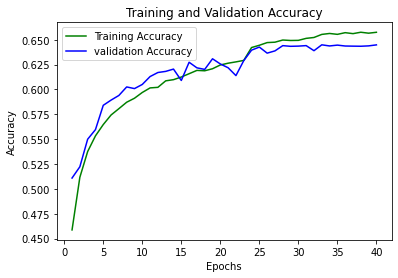

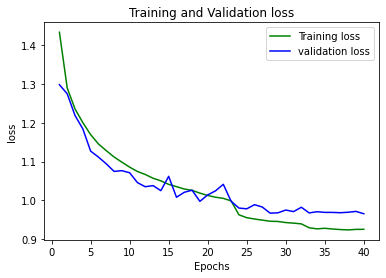

In [10]:
history_dict = history.history
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

##################################PREDICTIONS###########################


In [ ]:
kidney_array = []
i=0
# Note:if you want to test the bad model you would need to change from model.predict to badmodel.predict
predictions = model.predict(test_dataset)

while i <  len(predictions):
  if np.argmax(predictions[i])==0 :
    kidney_array.append("0")

  elif np.argmax(predictions[i])==1 :
    kidney_array.append("1")    

  elif np.argmax(predictions[i])==2 :
    kidney_array.append("2")

  elif np.argmax(predictions[i])==3 :
    kidney_array.append("3")

  elif np.argmax(predictions[i])==4 :
    kidney_array.append("4")

  elif np.argmax(predictions[i])==5 :
    kidney_array.append("5")

  elif np.argmax(predictions[i])==6 :
    kidney_array.append("6")

  elif np.argmax(predictions[i])==7 :
    kidney_array.append("7")

  i=i+1
DataFrame(data={'Cell type': kidney_array}).to_csv('predictions.csv', index_label='Id')

######################KAGLE SUBMISSION#####################

In [ ]:
!python3 /usr/local/bin/kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

100% 380k/380k [00:03<00:00, 103kB/s]
Successfully submitted to COM2028 21/22 CW